In [4]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
plt.style.use("ggplot")
np.random.seed(1234)


np.set_printoptions(formatter={'all': lambda x: '%3f' %x})

In [13]:
from IPython.display import Image
from scipy.stats import bernoulli, binom
from numpy.core.umath_tests import matrix_multiply as nm
from scipy.optimize import minimize

Expectation Maximizatio (EM) Algorithm
Review of Jensen’s inequality
Concavity of log function
Example of coin tossing with missing informaiton to provide context
Derivation of EM equations
Illustration of EM convergence
Derivation of update equations of coin tossing example
Code for coin tossing example
Derivation of update equatiosn for mixture of Gaussians
Code for mixture of Gaussians

Jensen’s inequality
For a convex function ff, E[f(x)]≥f(E[x])E[f(x)]≥f(E[x]). Flip the sign for a concave function.

A function f(x)f(x) is convex if f′′(x)≥0f″(x)≥0 everywhere in its domain. For example, if f(x)=logxf(x)=log⁡x, f′′(x)=−1/x2f″(x)=−1/x2, so the log function is concave for x∈(0,∞]x∈(0,∞]. A visual illustration of Jensen’s inequality is shown below.

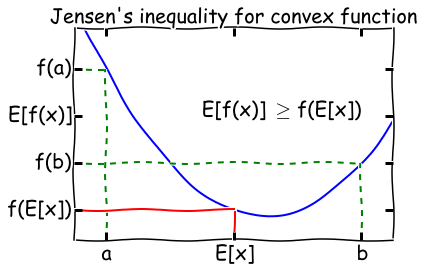

In [5]:
Image(filename='jensen.png')

When is Jensen’s inequality an equality? From the diagram, we can see that this only happens if the function f(x) is a constant! We will make use of this fact later on in the lecture.

Maximum likelihood with complete information
Consider an experiment with coin A that has a probability θA of heads, and a coin B that has a probability θB of tails. We draw mm samples as follows - for each sample, pick one of the coins at random, flip it nn times, and record the number of heads and tails (that sum to nn). If we recorded which coin we used for each sample, we have complete information and can estimate θAθA and θBθB in closed form. To be very explicit, suppose we drew 5 samples with the number of heads and tails represented as a vector xx, and the sequence of coins chosen was A,A,B,A,B. Then the complete log likelihood is

logp(x1;θA)+logp(x2;θA)+ logp(x3;θB)+logp(x4;θA)+logp(x5;θB)
log⁡p(x1;θA)+log⁡p(x2;θA)+ logp(x3;θB)+log⁡p(x4;θA)+log⁡p(x5;θB)

where p(xi;θ)p(xi;θ) is the binomial distribtion PMF with n=m and p=θ. We will use zi to indicate the label of the ith coin, that is - whether we used coin AA or BB to gnerate the ithith sample.

Coin toss example from What is the expectation maximization algorithm?
Solving for complete likelihood using minimization

In [6]:
def neg_loglik(thetas, n, xs, zs):
    return -np.sum([binom(n, thetas[z]).logpmf(x) for (x, z) in zip(xs, zs)])

In [8]:
m = 10
theta_A = 0.8
theta_B = 0.3
theta_0 = [theta_A, theta_B]

coin_A = bernoulli(theta_A)
coin_B = bernoulli(theta_B)

xs = map(sum, [coin_A.rvs(m), coin_A.rvs(m), coin_B.rvs(m), coin_A.rvs(m), coin_B.rvs(m)])
zs = [0,0,1,0,1]

In [9]:
#Exact Solution
xs = np.array(xs)
xs

array([7.000000, 9.000000, 2.000000, 8.000000, 2.000000])

In [11]:
ml_A = np.sum(xs[[0,1,3]])/(3.0*m)
ml_B = np.sum(xs[[2,4]])/(2.0*m)
ml_A, ml_B

(0.80000000000000004, 0.20000000000000001)

In [14]:
#Numerical Estimate
bnds = [(0,1), (0,1)]
minimize(neg_loglik, [0.5, 0.5], args = (m,xs,zs), bounds=bnds, method='tnc', options={'maxiter': 100})

     fun: 6.5100568718230667
     jac: array([0.000013, 0.000009])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 24
     nit: 8
  status: 1
 success: True
       x: array([0.800000, 0.200000])

Incomplete information--
However, if we did not record the coin we used, we have missing data and the problem of estimating θθ is harder to solve. One way to approach the problem is to ask - can we assign weights wiwi to each sample according to how likely it is to be generated from coin AA or coin BB?

With knowledge of wiwi, we can maximize the likelihod to find θθ. Similarly, given wiwi, we can calculate what θθ should be. So the basic idea behind Expectation Maximization (EM) is simply to start with a guess for θθ, then calculate zz, then update θθ using this new value for zz, and repeat till convergence. The derivation below shows why the EM algorithm using this “alternating” updates actually works.

A verbal outline of the derivtion - first consider the log likelihood function as a curve (surface) where the base is θθ. Find another function QQ of θθ that is a lower bound of the log-likelihood but touches the log likelihodd function at some θθ (E-step). Next find the value of θθ that maximizes this function (M-step). Now find yet antoher function of θθ that is a lower bound of the log-likelihood but touches the log likelihodd function at this new θθ. Now repeat until convergence - at this point, the maxima of the lower bound and likelihood functions are the same and we have found the maximum log likelihood. See illustratioin below.

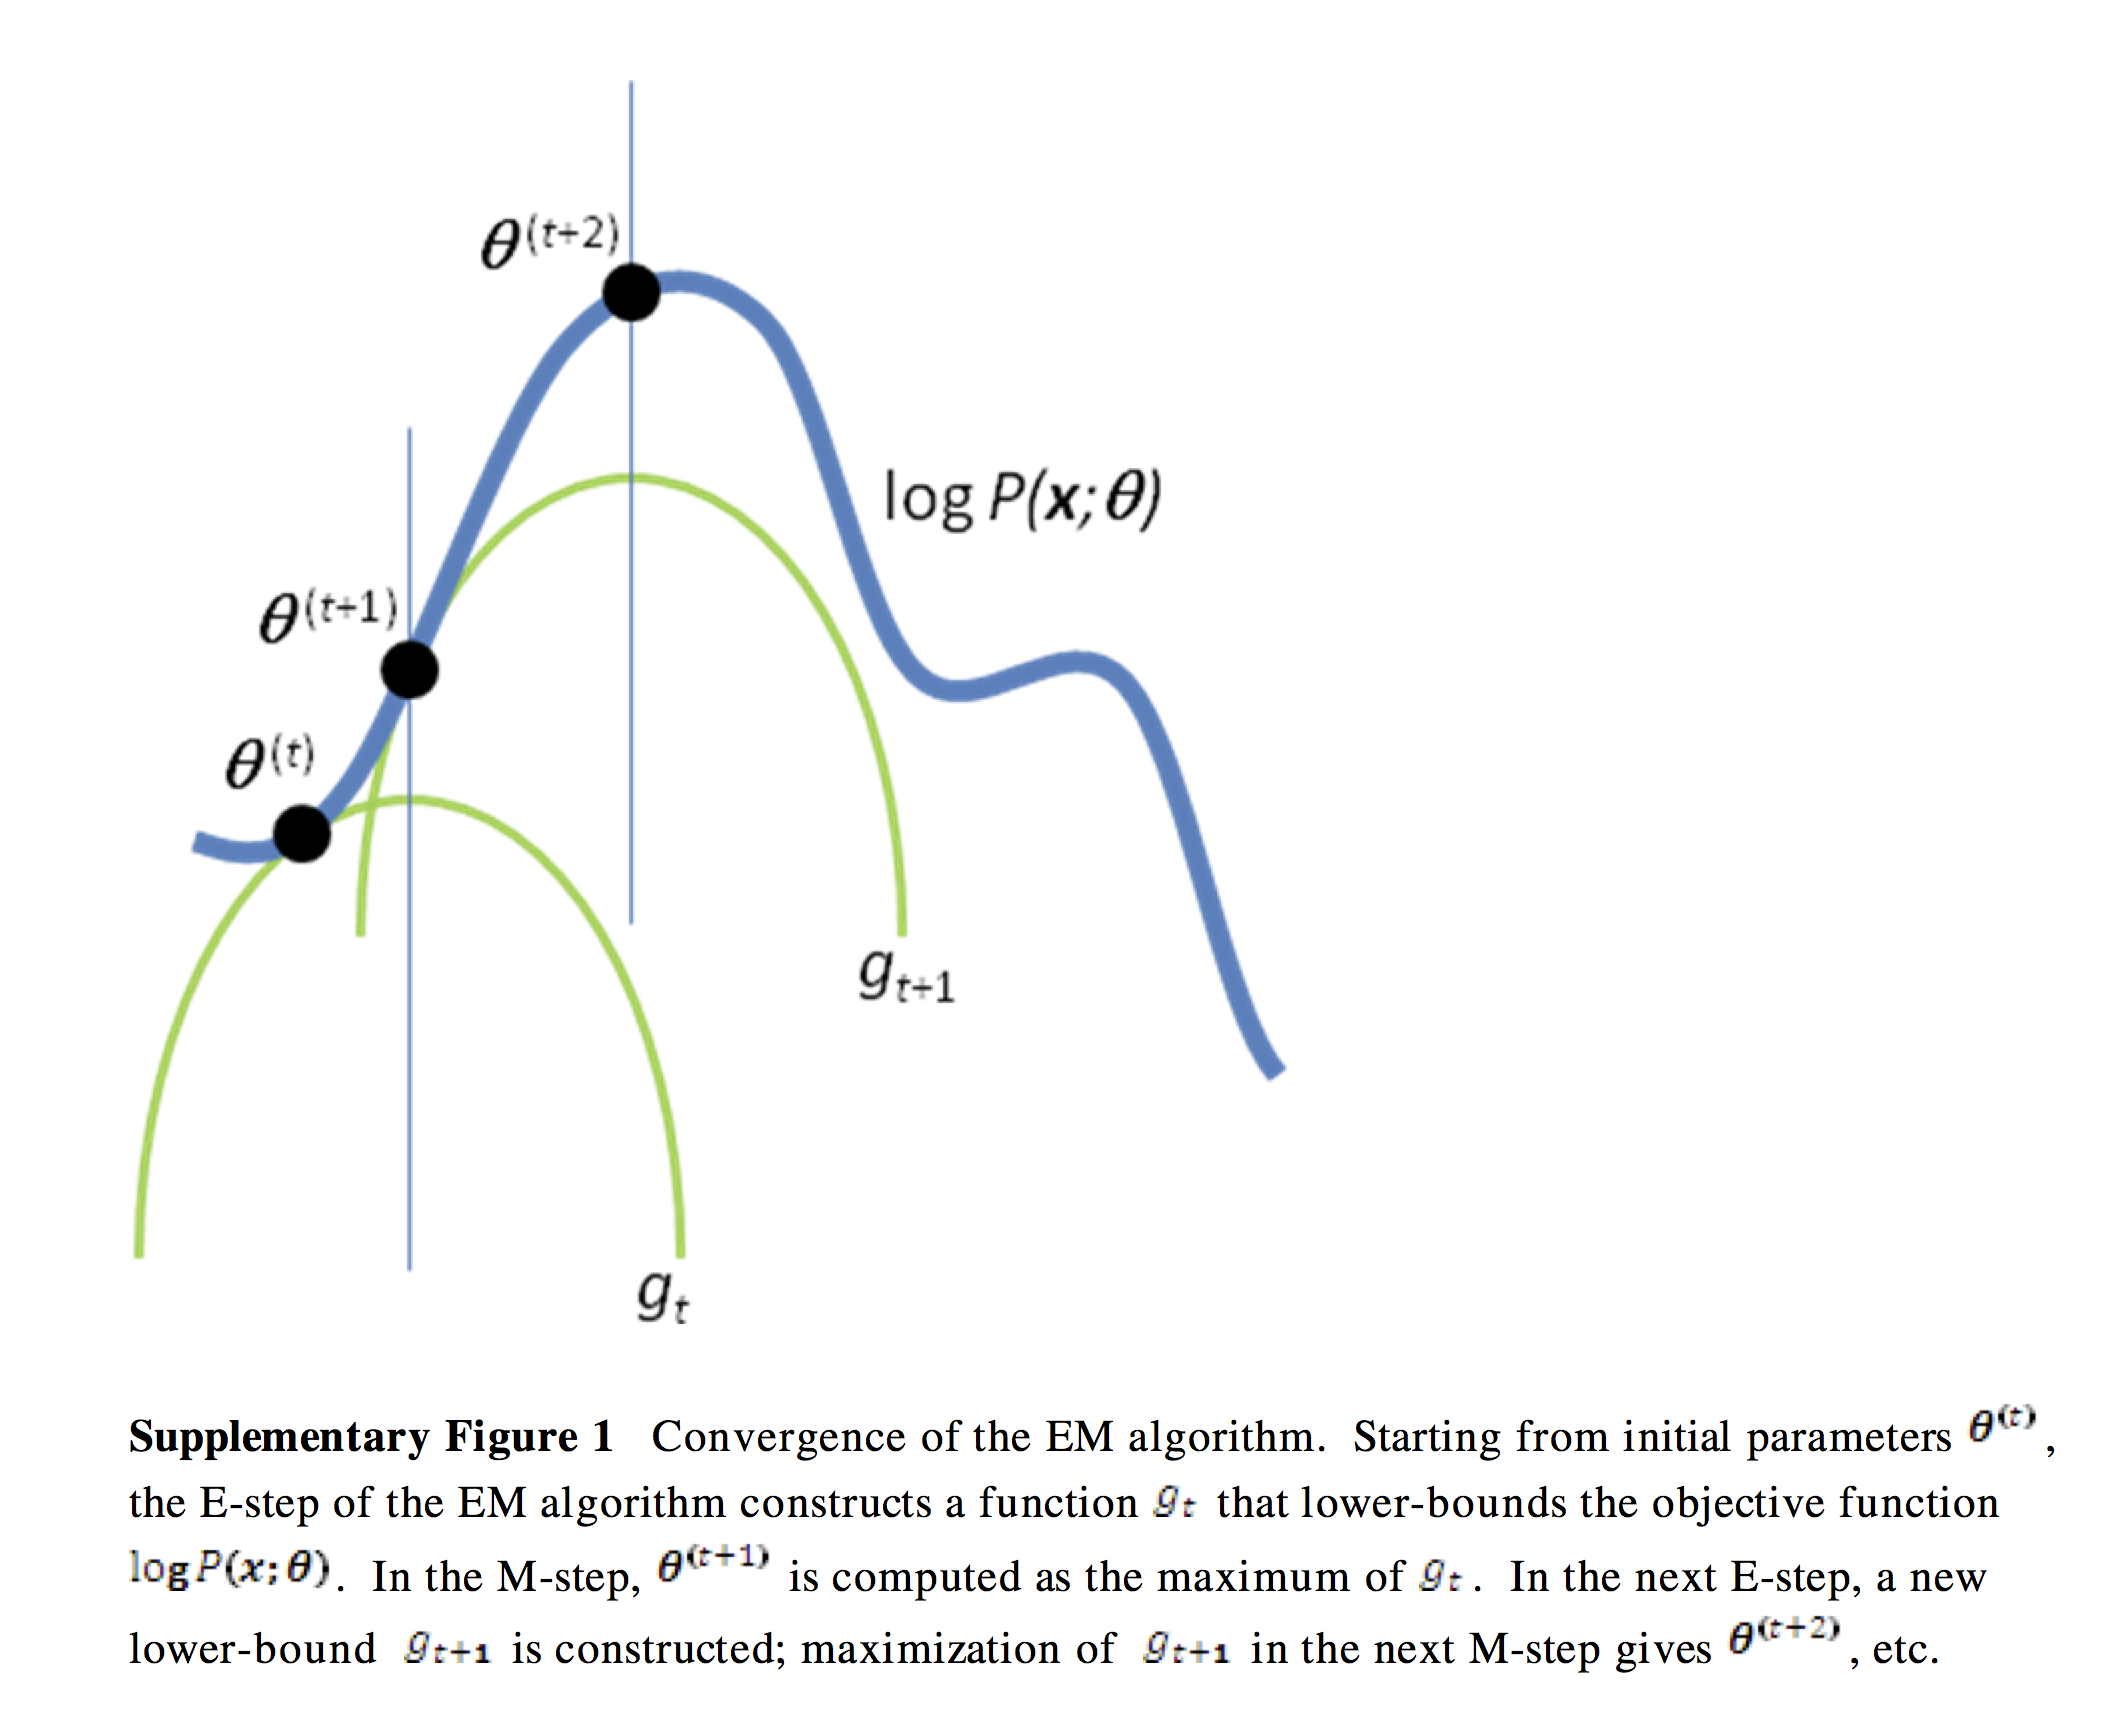

In [21]:
Image(filename='em.png', width = 800)

The only remaining step is how to find the functions that are lower bounds of the log likelihood. This will require a little math using Jensen’s inequality, and is shown in the next section.

In the E-step, we identify a function which is a lower bound for the log-likelikelihood

How do we choose the distribution QiQi? We want the Q function to touch the log-likelihood, and know that Jensen’s inequality is an equality only if the function is constant. So

So QiQi is just the posterior distribution of zizi, and this completes the E-step.

In the M-step, we find the value of θθ that maximizes the Q function, and then we iterate over the E and M steps until convergence.

So we see that EM is an algorihtm for maximum likelikhood optimization when there is missing inforrmaiton - or when it is useful to add latent augmented variables to simplify maximum likelihood calculatoins.

ii indicates the sample
jj indicates the coin
ll is an index running through each of the coins
θθ is the probability of the coin being heads
ϕϕ is the probability of choosing a particular coin
hh is the number of heads in a sample
nn is the number of coin tosses in a sample
kk is the number of coins
mm is the number of samples
For the E-step, with each sample we have

For the M-step, we need to find the value of θθ that maximises the QQ function

We can differentiate and solve for each component θsθs where the derivative vanishes

In [22]:
xs = np.array([(5,5), (9,1), (8,2), (4,6), (7,3)])
thetas = np.array([[0.6, 0.4], [0.5, 0.5]])

tol = 0.01
max_iter = 100

ll_old = 0
for i in range(max_iter):
    ws_A = []
    ws_B = []

    vs_A = []
    vs_B = []

    ll_new = 0

    # E-step: calculate probability distributions over possible completions
    for x in xs:

        # multinomial (binomial) log likelihood
        ll_A = np.sum([x*np.log(thetas[0])])
        ll_B = np.sum([x*np.log(thetas[1])])

        # [EQN 1]
        denom = np.exp(ll_A) + np.exp(ll_B)
        w_A = np.exp(ll_A)/denom
        w_B = np.exp(ll_B)/denom

        ws_A.append(w_A)
        ws_B.append(w_B)

        # used for calculating theta
        vs_A.append(np.dot(w_A, x))
        vs_B.append(np.dot(w_B, x))

        # update complete log likelihood
        ll_new += w_A * ll_A + w_B * ll_B

    # M-step: update values for parameters given current distribution
    # [EQN 2]
    thetas[0] = np.sum(vs_A, 0)/np.sum(vs_A)
    thetas[1] = np.sum(vs_B, 0)/np.sum(vs_B)
    # print distribution of z for each x and current parameter estimate

    print "Iteration: %d" % (i+1)
    print "theta_A = %.2f, theta_B = %.2f, ll = %.2f" % (thetas[0,0], thetas[1,0], ll_new)

    if np.abs(ll_new - ll_old) < tol:
        break
    ll_old = ll_new

Iteration: 1
theta_A = 0.71, theta_B = 0.58, ll = -32.69
Iteration: 2
theta_A = 0.75, theta_B = 0.57, ll = -31.26
Iteration: 3
theta_A = 0.77, theta_B = 0.55, ll = -30.76
Iteration: 4
theta_A = 0.78, theta_B = 0.53, ll = -30.33
Iteration: 5
theta_A = 0.79, theta_B = 0.53, ll = -30.07
Iteration: 6
theta_A = 0.79, theta_B = 0.52, ll = -29.95
Iteration: 7
theta_A = 0.80, theta_B = 0.52, ll = -29.90
Iteration: 8
theta_A = 0.80, theta_B = 0.52, ll = -29.88
Iteration: 9
theta_A = 0.80, theta_B = 0.52, ll = -29.87


In [23]:
xs = np.array([(5,5), (9,1), (8,2), (4,6), (7,3)])
thetas = np.array([[0.6, 0.4], [0.5, 0.5]])

tol = 0.01
max_iter = 100

ll_old = -np.infty
for i in range(max_iter):
    ll_A = np.sum(xs * np.log(thetas[0]), axis=1)
    ll_B = np.sum(xs * np.log(thetas[1]), axis=1)
    denom = np.exp(ll_A) + np.exp(ll_B)
    w_A = np.exp(ll_A)/denom
    w_B = np.exp(ll_B)/denom

    vs_A = w_A[:, None] * xs
    vs_B = w_B[:, None] * xs

    thetas[0] = np.sum(vs_A, 0)/np.sum(vs_A)
    thetas[1] = np.sum(vs_B, 0)/np.sum(vs_B)

    ll_new = w_A.dot(ll_A) + w_B.dot(ll_B)

    print "Iteration: %d" % (i+1)
    print "theta_A = %.2f, theta_B = %.2f, ll = %.2f" % (thetas[0,0], thetas[1,0], ll_new)

    if np.abs(ll_new - ll_old) < tol:
        break
    ll_old = ll_new

Iteration: 1
theta_A = 0.71, theta_B = 0.58, ll = -32.69
Iteration: 2
theta_A = 0.75, theta_B = 0.57, ll = -31.26
Iteration: 3
theta_A = 0.77, theta_B = 0.55, ll = -30.76
Iteration: 4
theta_A = 0.78, theta_B = 0.53, ll = -30.33
Iteration: 5
theta_A = 0.79, theta_B = 0.53, ll = -30.07
Iteration: 6
theta_A = 0.79, theta_B = 0.52, ll = -29.95
Iteration: 7
theta_A = 0.80, theta_B = 0.52, ll = -29.90
Iteration: 8
theta_A = 0.80, theta_B = 0.52, ll = -29.88
Iteration: 9
theta_A = 0.80, theta_B = 0.52, ll = -29.87


In [25]:
xs = np.array([(5,5), (9,1), (8,2), (4,6), (7,3)])
thetas = np.array([[0.6, 0.4], [0.5, 0.5]])

tol = 0.01
max_iter = 100

ll_old = -np.infty
for i in range(max_iter):
    ll_A = np.sum(xs * np.log(thetas[0]), axis=1)
    ll_B = np.sum(xs * np.log(thetas[1]), axis=1)
    denom = np.exp(ll_A) + np.exp(ll_B)
    w_A = np.exp(ll_A)/denom
    w_B = np.exp(ll_B)/denom

    vs_A = w_A[:, None] * xs
    vs_B = w_B[:, None] * xs

    thetas[0] = np.sum(vs_A, 0)/np.sum(vs_A)
    thetas[1] = np.sum(vs_B, 0)/np.sum(vs_B)

    ll_new = w_A.dot(ll_A) + w_B.dot(ll_B) - w_A.dot(np.log(w_A)) - w_B.dot(np.log(w_B))
    print "Iteration: %d" % (i+1)
    print "theta_A = %.2f, theta_B = %.2f, ll = %.2f" % (thetas[0,0], thetas[1,0], ll_new)

    if np.abs(ll_new - ll_old) < tol:
        break
    ll_old = ll_new

Iteration: 1
theta_A = 0.71, theta_B = 0.58, ll = -29.63
Iteration: 2
theta_A = 0.75, theta_B = 0.57, ll = -28.39
Iteration: 3
theta_A = 0.77, theta_B = 0.55, ll = -28.26
Iteration: 4
theta_A = 0.78, theta_B = 0.53, ll = -28.16
Iteration: 5
theta_A = 0.79, theta_B = 0.53, ll = -28.12
Iteration: 6
theta_A = 0.79, theta_B = 0.52, ll = -28.11
Iteration: 7
theta_A = 0.80, theta_B = 0.52, ll = -28.10


In [26]:
def em(xs, thetas, max_iter=100, tol=1e-6):
    """Expectation-maximization for coin sample problem."""

    ll_old = -np.infty
    for i in range(max_iter):
        ll = np.array([np.sum(xs * np.log(theta), axis=1) for theta in thetas])
        lik = np.exp(ll)
        ws = lik/lik.sum(0)
        vs = np.array([w[:, None] * xs for w in ws])
        thetas = np.array([v.sum(0)/v.sum() for v in vs])
        ll_new = np.sum([w*l for w, l in zip(ws, ll)])
        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new
    return i, thetas, ll_new

In [27]:
xs = np.array([(5,5), (9,1), (8,2), (4,6), (7,3)])
thetas = np.array([[0.6, 0.4], [0.5, 0.5]])

i, thetas, ll = em(xs, thetas)
print i
for theta in thetas:
    print theta
print ll

18
[0.796789 0.203211]
[0.519583 0.480417]
-29.868676155


In [28]:
np.random.seed(1234)

n = 100
p0 = 0.8
p1 = 0.35
xs = np.concatenate([np.random.binomial(n, p0, n/2), np.random.binomial(n, p1, n/2)])
xs = np.column_stack([xs, n-xs])
np.random.shuffle(xs)

In [29]:
results = [em(xs, np.random.random((2,2))) for i in range(10)]
i, thetas, ll =  sorted(results, key=lambda x: x[-1])[-1]
print i
for theta in thetas:
    print theta
print ll

4
[0.351600 0.648400]
[0.798200 0.201800]
-5756.59565198
